# Model Evaluation
The goal here is to load in a model and evaluate its performance on a random valid 3d MRI scan. The goal is to visualize it.

In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import transforms
import nibabel as nib
import random
from torch.utils.data import DataLoader
import time



final_project_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215' # vm
data_folder_path = os.path.join(final_project_path, 'BraTS2020')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name: ", torch.cuda.get_device_name(0))
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert bytes to gigabytes
    cached_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Allocated Memory: {allocated_memory:.2f} GB")
    print(f"Cached Memory: {cached_memory:.2f} GB")
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Total GPU Memory: {total_memory:.2f} GB")
else:
    print("CUDA is not available. Cannot print memory usage.")
    device = torch.device('cpu')



GPU name:  Tesla T4
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB
Total GPU Memory: 14.58 GB


In [2]:
def create_data_dictionary(folder_path):
    data_dict = {}
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    
    for idx, subfolder in enumerate(subfolders):
        abs_path = os.path.join(folder_path, subfolder)
        data_dict[idx] = {'absolute_path': abs_path, 'folder_name': subfolder}
    
    return data_dict

data_path_dictionary_train = create_data_dictionary(train_folder_path)
data_path_dictionary_valid = create_data_dictionary(valid_folder_path)



In [3]:
## all data is stored in (240,240,155) 

class ImageDataset(Dataset):
    def __init__(self, data_path_dictionary):
        self.data_path_dictionary = data_path_dictionary

    def __len__(self):
        # print(len(self.annotations["images"]))
        return len(self.data_path_dictionary)

    def __getitem__(self, idx):
        
        folder_name = self.data_path_dictionary[idx]["folder_name"]
        folder_path = self.data_path_dictionary[idx]["absolute_path"]
        
        seg_path = os.path.join(folder_path, folder_name + '_seg.nii')
        t1_path = os.path.join(folder_path, folder_name + '_t1.nii')
        t1ce_path = os.path.join(folder_path, folder_name + '_t1ce.nii')
        t2_path = os.path.join(folder_path, folder_name + '_t2.nii')
        flair_path = os.path.join(folder_path, folder_name + '_flair.nii')
        
        # Load .nii files as nparrays
        seg_img = nib.load(seg_path).get_fdata()
        
        t1_img = nib.load(t1_path).get_fdata() #combine these ones
        t1ce_img = nib.load(t1ce_path).get_fdata()#combine these ones
        t2_img = nib.load(t2_path).get_fdata()#combine these ones
        flair_img = nib.load(flair_path).get_fdata()#combine these ones
        
        # Combine the MRI scans into a single 4-channel image
        combined_mri = np.stack([t1_img, t1ce_img, t2_img, flair_img], axis=0)  
        
        # Convert combined_mri and seg_img to torch tensors
        # combined_mri = torch.tensor(combined_mri, dtype=torch.float32)
        # seg_img = torch.tensor(seg_img, dtype=torch.float32)
        combined_mri = torch.tensor(combined_mri, dtype=torch.int32)
        seg_img = torch.tensor(seg_img, dtype=torch.int32)

        
        #convert to binary problem:
        seg_img[seg_img != 0] = 1
        
        return combined_mri, seg_img

val_dataset = ImageDataset(data_path_dictionary_valid)


# Load the Model

In [4]:
from seg_models import UNet, UNetPaper
    
    
# Define the number of classes
num_output_classes = 1 #normally should be 5
num_input_channels = 4

# Custom Models
model = UNet(num_input_channels, num_output_classes)

# Paper Models
# model = UNetPaper(num_input_channels, num_output_classes)

# Load the saved weights
final_project_path 
saved_models_path = os.path.join(final_project_path, 'saved_models')


####### Change the name here #########
saved_model_path = os.path.join(saved_models_path, 'train_unet1_bce_lr1e-5_20e')

# Add the file name
saved_weights_path = 'best_unet.pth'
saved_weights_path = os.path.join(saved_model_path, saved_weights_path)
saved_weights = torch.load(saved_weights_path)

# Load the weights into the model
model.load_state_dict(saved_weights)
model = model.to(device)
print("model", model)

model UNet(
  (encoder_conv1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck)

# Evaluation on a Valid Patient

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
import cv2
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
from scipy import io


def update(frame, frames):
    ax.clear()
    ax.imshow(frames[frame])
    ax.set_title(f"Layer {frame}")
    ax.axis('off')
    return ax,

def overlay_mask_on_flair(flair_img, mask_img):
    # Convert flair image to RGB
    flair_rgb = np.stack([flair_img, flair_img, flair_img], axis=-1)
    
    # Normalize mask image
    mask_norm = (mask_img - np.min(mask_img)) / (np.max(mask_img) - np.min(mask_img))
    
    # Create alpha channel for mask
    alpha = 0.5  # Adjust transparency here
    mask_alpha = np.zeros_like(flair_img)
    mask_alpha[mask_img > 0] = alpha
    
    # Create overlay image
    overlay_img = flair_rgb.copy()
    overlay_img[:, :, 0] = flair_rgb[:, :, 0] * (1 - mask_norm) + mask_norm * 255
    overlay_img[:, :, 1] = flair_rgb[:, :, 1] * (1 - mask_norm)
    overlay_img[:, :, 2] = flair_rgb[:, :, 2] * (1 - mask_norm)
    
    # Apply alpha channel
    overlay_img = overlay_img.astype(np.uint8)
    overlay_img = np.dstack((overlay_img, mask_alpha))
    
    return overlay_img

def red_mask_on_flair(flair_img, mask_img, display_threshold):
    # Convert flair image to RGB
    flair_rgb = np.stack([flair_img, flair_img, flair_img], axis=-1)
    
    
    # Normalize mask image
    mask_norm = (mask_img - np.min(mask_img)) / (np.max(mask_img) - np.min(mask_img))
    
    # Create overlay image
    red_overlay_img = flair_rgb.copy()
    red_overlay_img = red_overlay_img.astype(np.uint8)
    red_overlay_img = cv2.cvtColor(red_overlay_img, cv2.COLOR_RGB2BGR)
    
    # threshold applied
    sample_output = mask_img.copy()
    sample_output[sample_output >= display_threshold] = 1
    sample_output[sample_output < display_threshold] = 0
    
    sample_output = sample_output.astype(np.uint8)
    
    # apply overlay
    # Overlay the predicted mask on top of the original image
    red_color = np.array([255, 0, 0], dtype=np.uint8)
    red_overlay_img[sample_output == 1] = red_overlay_img[sample_output == 1] * 0.8 + red_color * 0.3  # Mix red with original image

    
    
    return red_overlay_img


def patient_eval(patient_number, model, val_dataset, device, display_threshold = 0.99, create_video = False):
    model.eval()
    combined_mri, seg_img = val_dataset.__getitem__(patient_number)
    print("combined_mri", combined_mri.shape)
    print("seg_img", seg_img.shape)
    
    if not create_video:
        for layer in range(seg_img.shape[2]):
            if(layer % 5 != 0):
                continue

            # Create a subplot with 1 row and 3 columns
            fig, axes = plt.subplots(1, 5, figsize=(15, 5))

            # Display the flair
            axes[0].imshow(combined_mri[0, :, :, layer], cmap='gray')
            axes[0].set_title("Flair")
            axes[0].axis('off')

            # Display the segmentation
            axes[1].imshow(seg_img[:, :, layer], cmap='hot')
            axes[1].set_title("Mask")
            axes[1].axis('off')

            # Get the prediction
            current_slice = combined_mri[:, :, :, layer].unsqueeze(0).float().to(device)
            prediction = model(current_slice).squeeze().cpu().detach().numpy()

            # Display the prediction
            axes[2].imshow(prediction, cmap='hot')
            axes[2].set_title("Prediction")
            axes[2].axis('off')

            # Overlay the prediction on the flair image
            overlay_img = overlay_mask_on_flair(combined_mri[0, :, :, layer], prediction)
            overlay_img = overlay_img[:, :, :3]
            axes[3].imshow(overlay_img)
            axes[3].set_title("Prediction Overlay")
            axes[3].axis('off')
            
            # Overlay the see through prediction on the flair image
            red_overlay_img = red_mask_on_flair(combined_mri[0, :, :, layer], prediction, display_threshold)
            axes[4].imshow(red_overlay_img)
            axes[4].set_title("99% Threshold Overlay")
            axes[4].axis('off')

            plt.show()

    
    if(create_video):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change codec as needed
        results_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215/results' # vm
        name = str(patient_number) + "_results.mp4"
        results_path = os.path.join(results_path, name)
        fps = 15
        frame_width = 480
        frame_height = 240
        output_video = cv2.VideoWriter(results_path, fourcc, fps, (frame_width, frame_height))
        
        
        numb_passes = 1 # Number of forward-backward passes
        layers_order = list(range(seg_img.shape[2])) + list(range(seg_img.shape[2] - 2, 0, -1))
        layers_order *= numb_passes  # Repeat the list numb_passes times
        
        for layer in layers_order:
            # Get the prediction
            current_slice = combined_mri[:, :, :, layer].unsqueeze(0).float().to(device)
            prediction = model(current_slice).squeeze().cpu().detach().numpy()

            # Overlay the prediction on the flair image
            overlay_img = overlay_mask_on_flair(combined_mri[0, :, :, layer], prediction)
            overlay_img = overlay_img[:, :, :3]
            overlay_img = overlay_img.astype(np.uint8)
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR)
            
            # Get Red overlay
            red_overlay_img = red_mask_on_flair(combined_mri[0, :, :, layer], prediction, display_threshold).astype(np.uint8)
            red_overlay_img = cv2.cvtColor(red_overlay_img, cv2.COLOR_RGB2BGR)
            # Combine the images
            combined_img = np.hstack((overlay_img, red_overlay_img))
            
            
            # Write some Text
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,10)
            fontScale              = 0.25
            fontColor              = (255,255,255)
            thickness              = 1
            lineType               = 2
            
            text_to_add = "Layer: " + str(layer) + ", Disp Threshold: " + str(display_threshold) + ", Max Certainity: " + str(np.max(prediction))
            overlay_img = cv2.putText(combined_img,text_to_add, 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                thickness,
                lineType)
            
            output_video.write(combined_img)
            
        output_video.release()
        
        print("Done:", name)
    
    
def generate_3d_visualization(patient_number, model, val_dataset, device, display_threshold):
    model.eval()
    combined_mri, seg_img = val_dataset.__getitem__(patient_number)
    print("combined_mri", combined_mri.shape)
    print("seg_img", seg_img.shape)

    num_layers = seg_img.shape[2]
    stacked_masks = np.zeros(seg_img.shape)
    for layer in range(num_layers):

        # Get the prediction
        current_slice = combined_mri[:, :, :, layer].unsqueeze(0).float().to(device)
        prediction = model(current_slice).squeeze().cpu().detach().numpy()
        stacked_masks[:, :, layer] = prediction
    print("stacked_masks", stacked_masks.shape)
    
   
    
    # Convert values above threshold to 1, and below threshold to 0
    binary_data = (stacked_masks > display_threshold).astype(int)
    print("binary_data", binary_data.shape)
    
    # Save stacked_masks to a MATLAB .mat file
    results_path = '/home/jws2215/e6691-2024spring-project-jwss-jws2215/results' # vm
    matlab_name = str(patient_number) + "_stacked_masks.mat"
    matlab_output_path = os.path.join(results_path, matlab_name)
        
    io.savemat(matlab_output_path, {'stacked_masks': stacked_masks})
    print("Stacked masks saved to stacked_masks.mat")


combined_mri torch.Size([4, 240, 240, 155])
seg_img torch.Size([240, 240, 155])


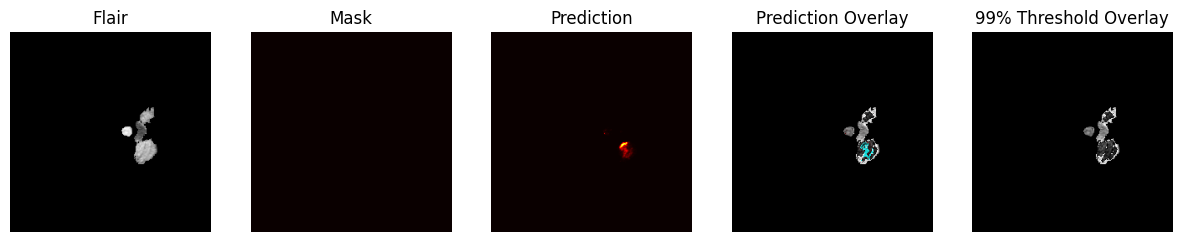

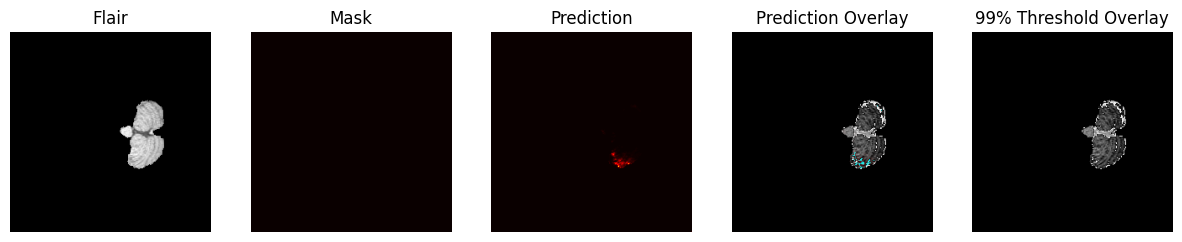

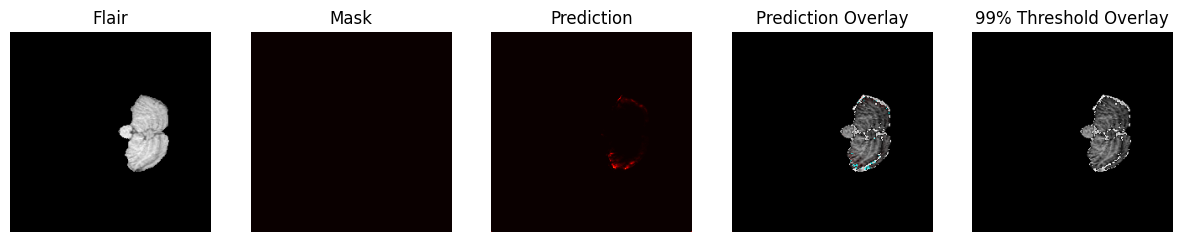

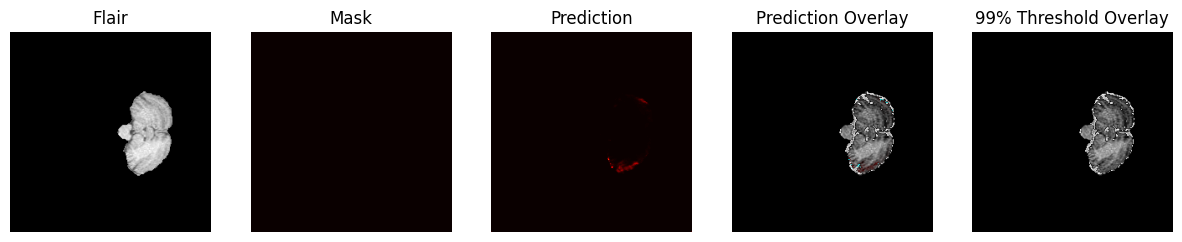

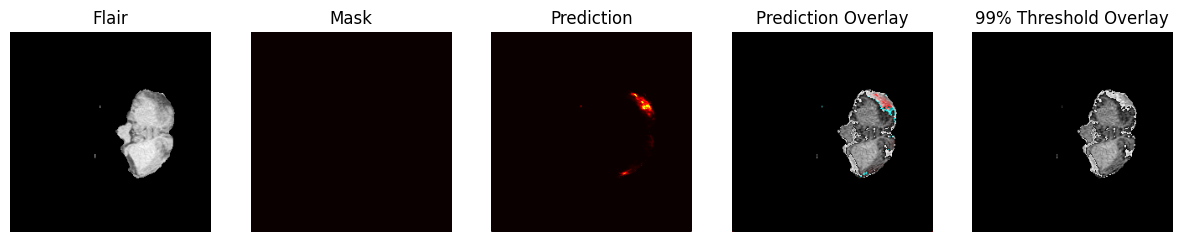

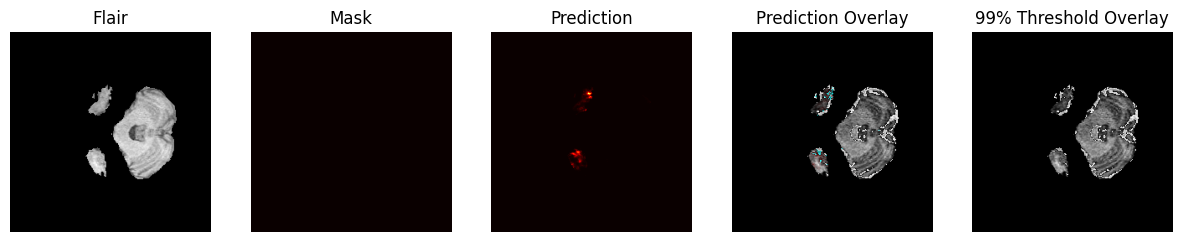

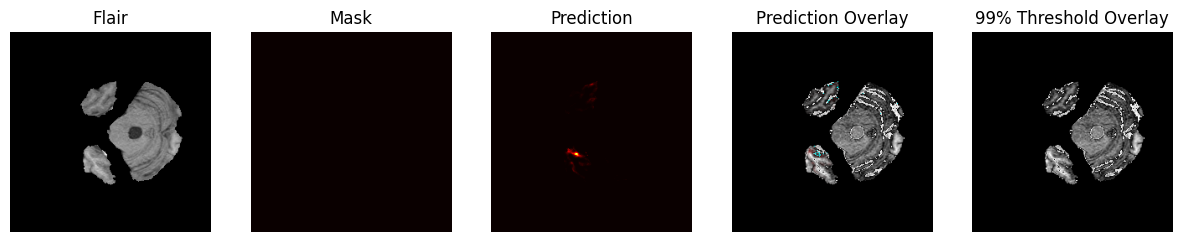

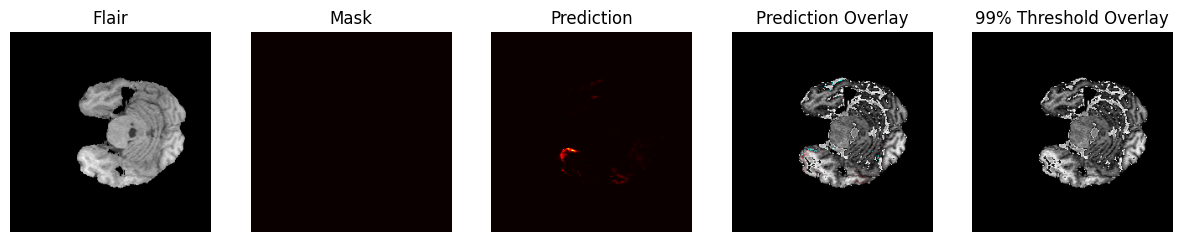

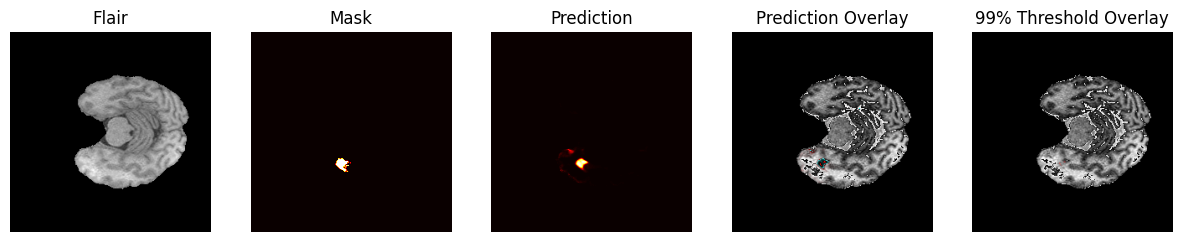

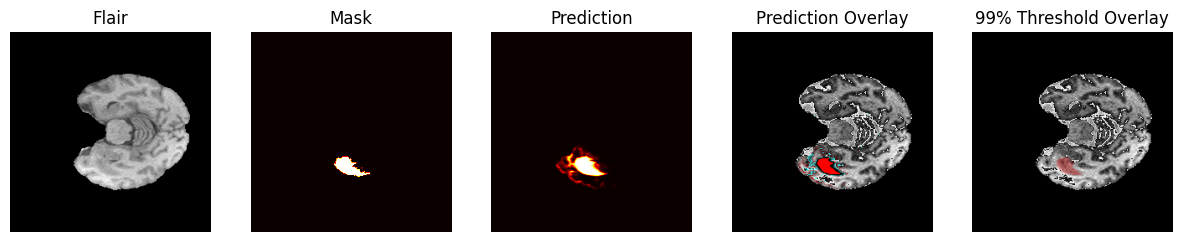

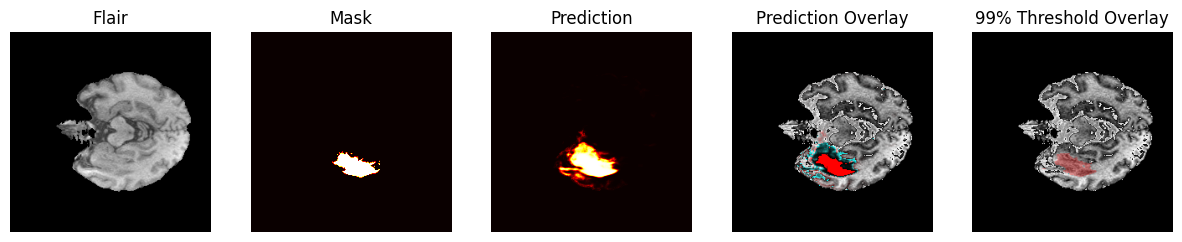

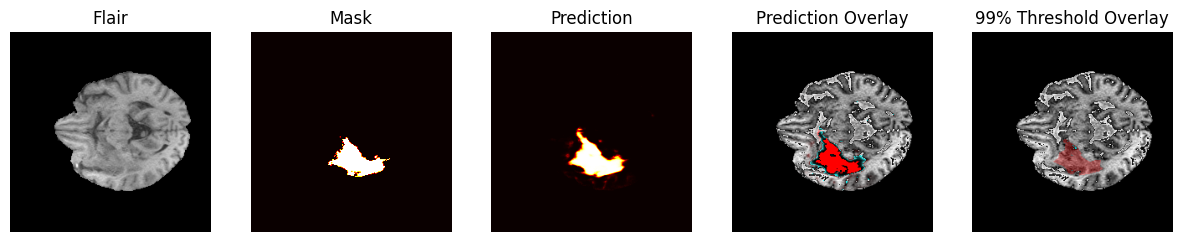

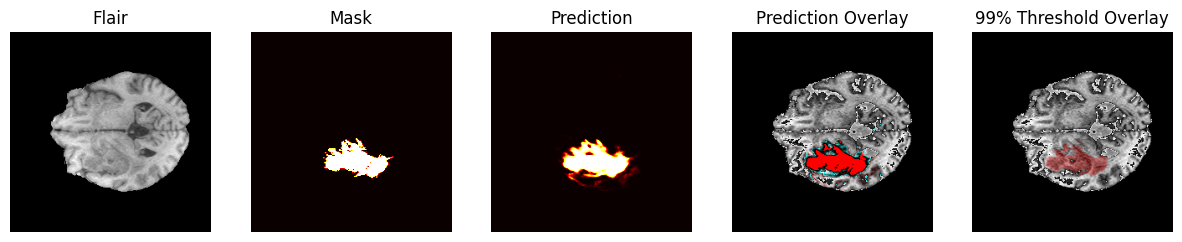

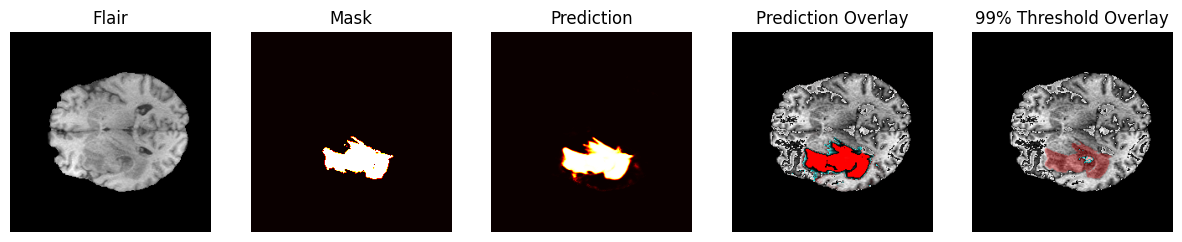

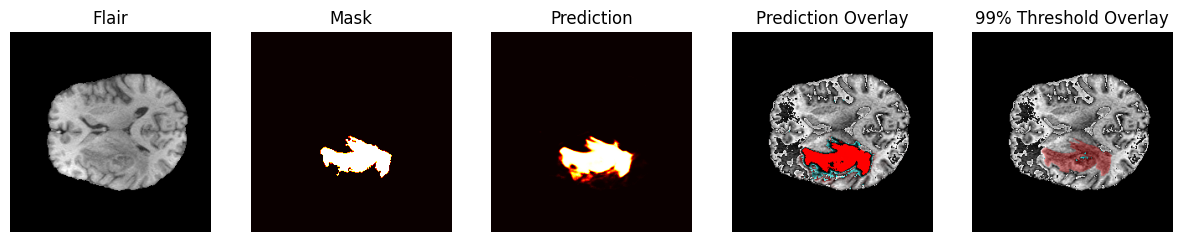

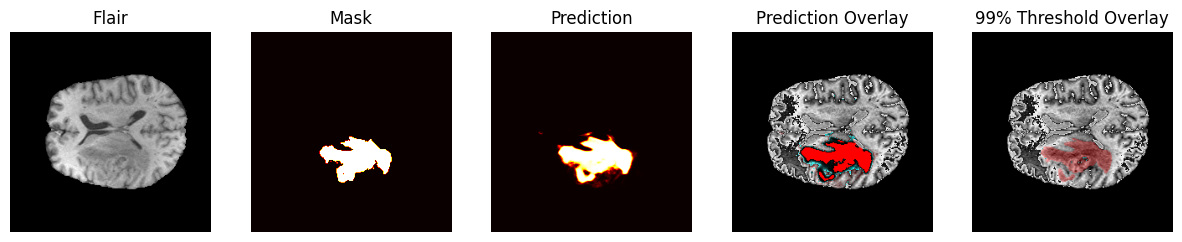

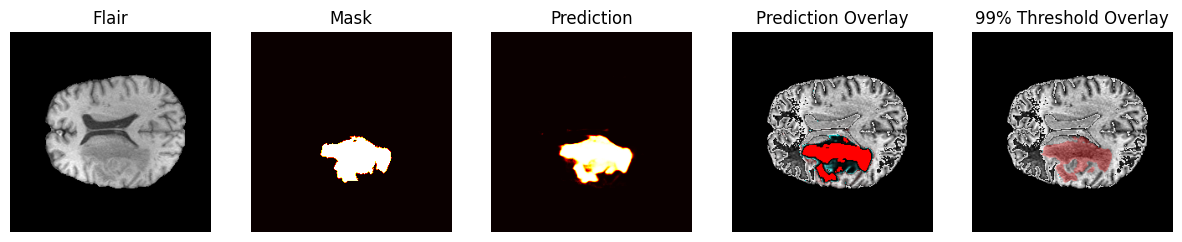

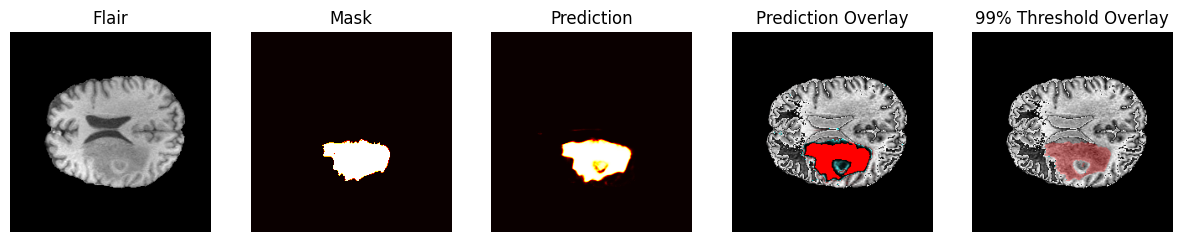

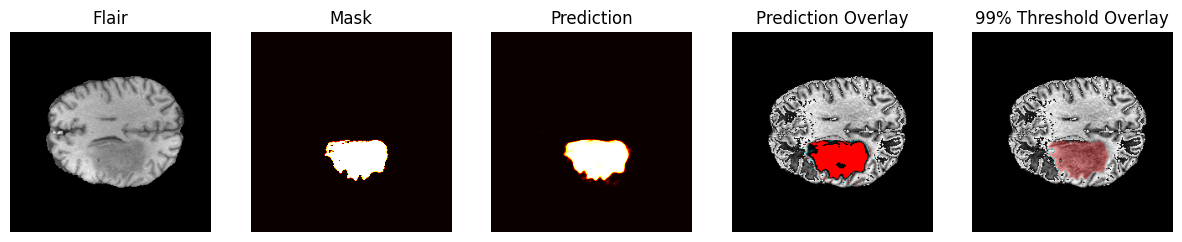

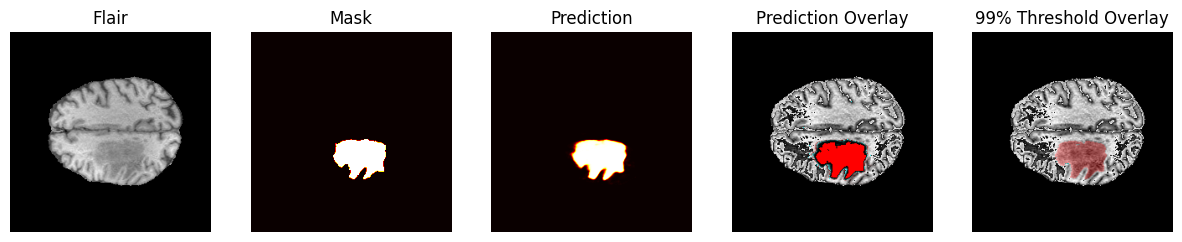

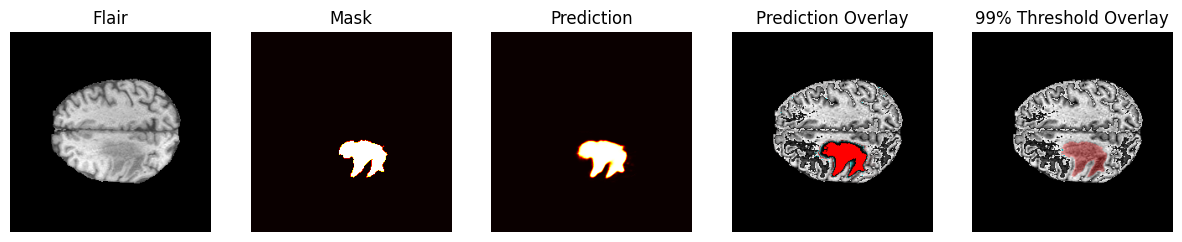

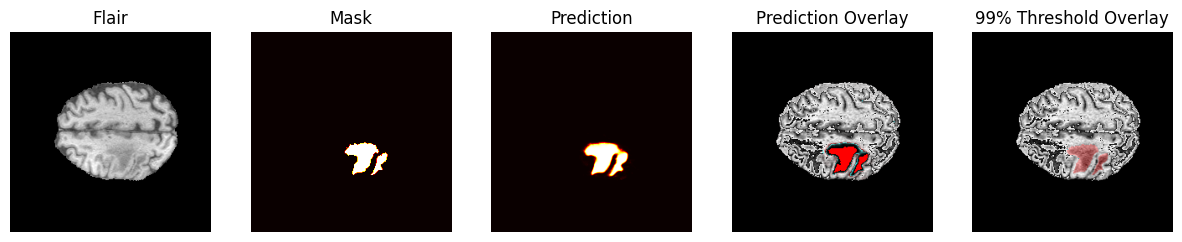

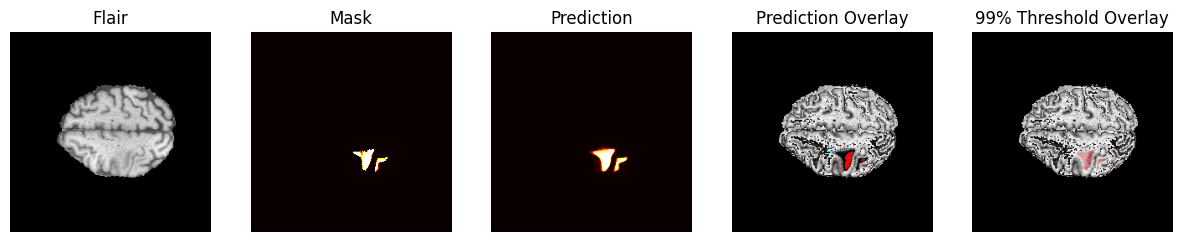

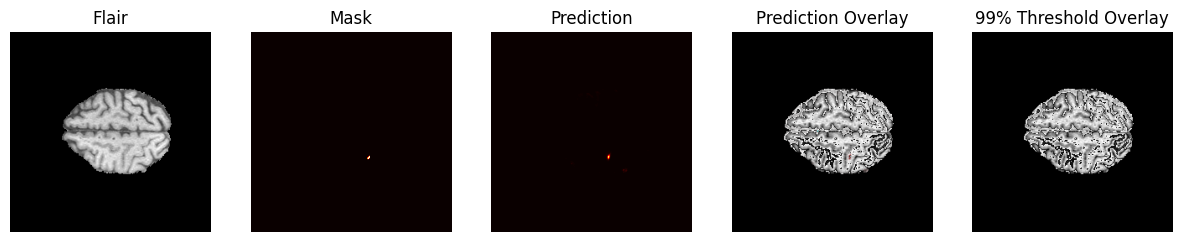

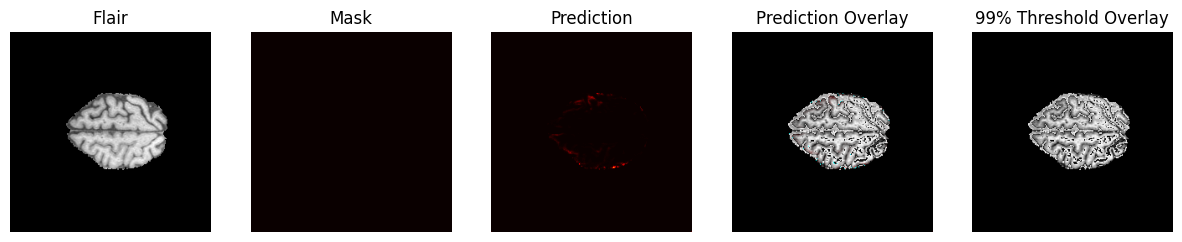

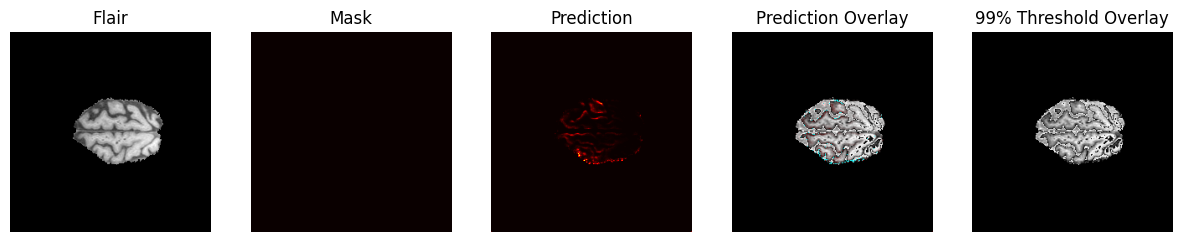

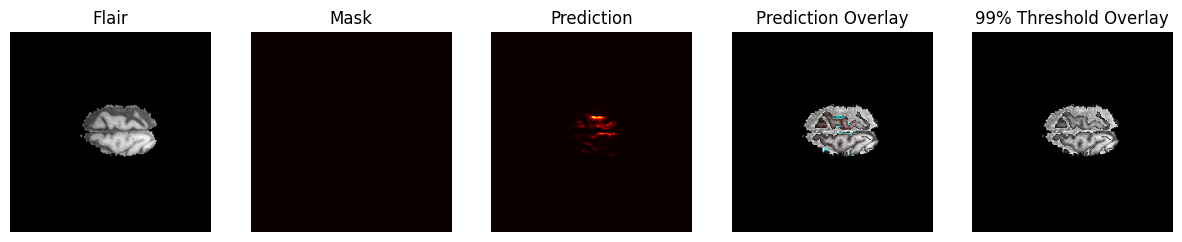

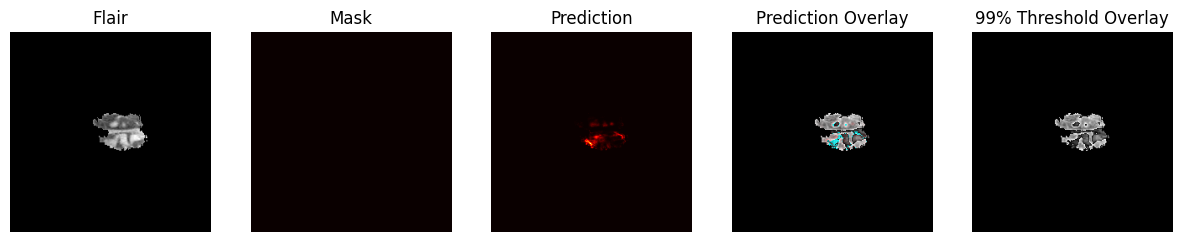

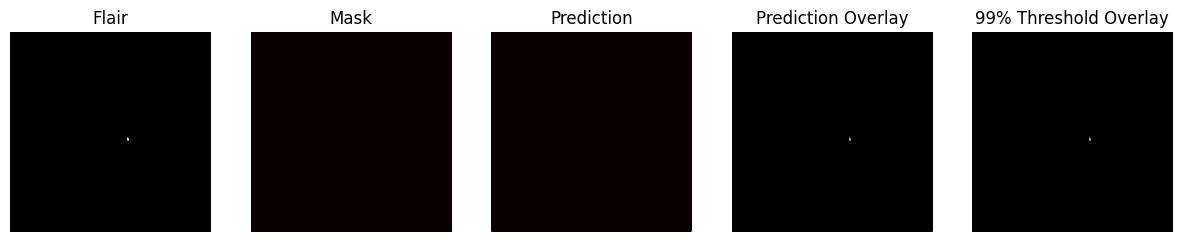

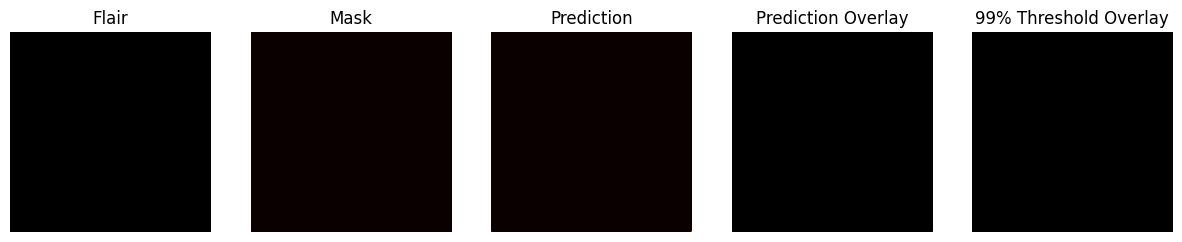

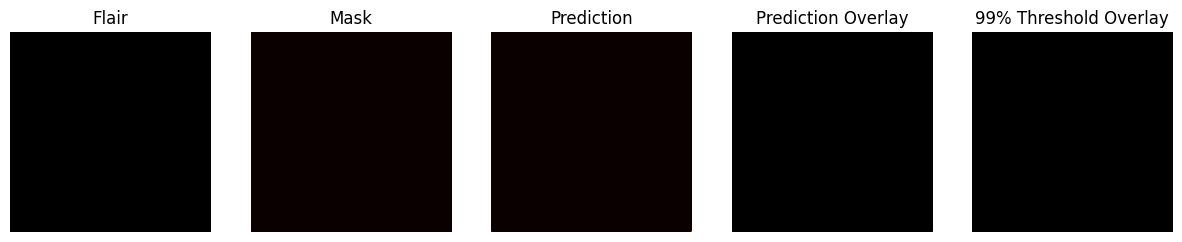

In [14]:
patient_number = 10 # range between 1-19
display_threshold = 0.95 # 99% threshold to apply.

patient_eval(patient_number, model, val_dataset, device, display_threshold = display_threshold, create_video = False)


In [13]:
# patient_number = 15 # range between 1-19
# display_threshold = 0.95 # 99% threshold to apply.

generate_3d_visualization(patient_number, model, val_dataset, device, display_threshold)


combined_mri torch.Size([4, 240, 240, 155])
seg_img torch.Size([240, 240, 155])
stacked_masks (240, 240, 155)
binary_data (240, 240, 155)
Stacked masks saved to stacked_masks.mat
